# Import libraries


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.patches as mpatches
import torch
import torchvision.models as models
from PIL import Image
from matplotlib.colors import ListedColormap
from torchvision import datasets, transforms
from sklearn.utils import resample
from torch.utils.data import random_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# import dbscan
from sklearn.cluster import DBSCAN


# FIle paths


In [2]:
# File paths for the dataset
BASE_PATH = "clean-dirty-preprocess-baseline/"

TRAIN_CONTAINER = os.path.join("full_data/container/")
TRAIN_NO_CONTAINER = os.path.join(BASE_PATH, "train/no_container/")

TEST_CONTAINER = os.path.join(BASE_PATH, "test/container/")
TEST_NO_CONTAINER = os.path.join(BASE_PATH, "test/no_container/")

# Create standard image size for the dataset
IMG_WIDTH = 256
IMG_HEIGHT = 256


# Transforming images


In [3]:
# Define the data transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert the image to PyTorch Tensor data type
        transforms.Resize(
            (IMG_HEIGHT, IMG_WIDTH), interpolation=Image.BILINEAR
        ),  # Resize the images
        transforms.CenterCrop(224),  # Crop the images to 224x224 about the center
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize the images
    ]
)


/home/intern/anaconda3/envs/feature_map_env/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


# Load data


In [4]:
# Load the dataset
dataset = datasets.ImageFolder(root="full_data/", transform=transform)
print(len(dataset))


3488


In [5]:
# Define the dataloaders for the training, validation, and test sets
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


# Load models


In [6]:
# Load the MobileNetV3 model
model = models.mobilenet_v3_small(pretrained=True, weights="IMAGENET1K_V1")

model.eval()


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

# Store features and labels


In [7]:
# Features and labels for the full dataset
features = []
labels = []
for images, label in dataloader:
    with torch.no_grad():
        outputs = model(images)
        features.append(outputs.numpy())
        labels.append(label.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)


In [8]:
print(
    features.shape
)  # 3488 is the number of samples, 3087 is the number of features extracted and 85 is the size of each feature
print(labels.shape)


(3488, 1000)
(3488,)


In [9]:
print(labels[:])
# 0 is no container, 1 is container


[0 0 0 ... 1 1 1]


In [10]:
# Visualize the clustered feature vectors using scatter plots, t-SNE, or PCA to gain insights into the learned features
# features_2d = features.reshape(features.shape[0], -1)
# print(features_2d.shape)


# Scale features

In [11]:
# Use standard scaler to scale the features

scaler = StandardScaler()
features_2d = scaler.fit_transform(features)
print(len(features_2d))
print(features_2d.shape)


3488
(3488, 1000)


In [12]:
del features


In [13]:
features_2d_0 = features_2d[labels==0]
features_2d_1 = features_2d[labels==1]

# Principal Component Analysis


In [14]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_2d)
print(pca_result.shape)

(3488, 2)


In [15]:
pca_result_0 = pca_result[labels==0]
pca_result_1 = pca_result[labels==1]

In [16]:
print(pca_result_1.shape)

(2266, 2)


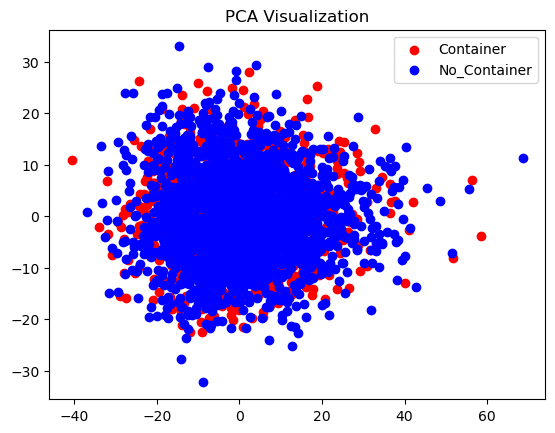

In [17]:
fig, ax = plt.subplots()

ax.scatter(pca_result_0[:, 0], pca_result_0[:, 1], c='red', label='Container')
ax.scatter(pca_result_1[:, 0], pca_result_1[:, 1], c='blue', label='No_Container')

plt.legend(loc="upper right")

# View the plot
%matplotlib inline
ax.set_title("PCA Visualization")
plt.show()

# K-means clustering


In [22]:
pca_result[:, 0].shape

(3488,)

In [23]:
pca_result

array([[-14.932908 ,   5.236133 ],
       [  2.242156 ,   2.762737 ],
       [ 12.244283 ,  -2.44797  ],
       ...,
       [  5.249909 ,  -2.3796275],
       [ -9.094733 ,  -9.108315 ],
       [ -2.5794344, -11.319228 ]], dtype=float32)

In [24]:
colors = ["red", "blue"]

/home/intern/anaconda3/envs/feature_map_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


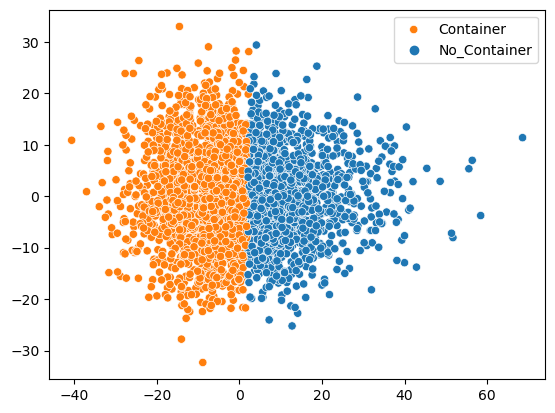

In [25]:
kmeans = MiniBatchKMeans(n_clusters=2, batch_size=500, random_state=0)
kmeans.fit(pca_result)


# Visualizing the clusters in 2D space using the first two principal components
# plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans.labels_)


# Create the legend with seaborn colurs

# Create legend with the same colors
# handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, ['Container', 'No_Container'])]
plt.legend(loc='upper right', labels=['Container', 'No_Container'])

%matplotlib inline
plt.show()

# Confusion Matrix


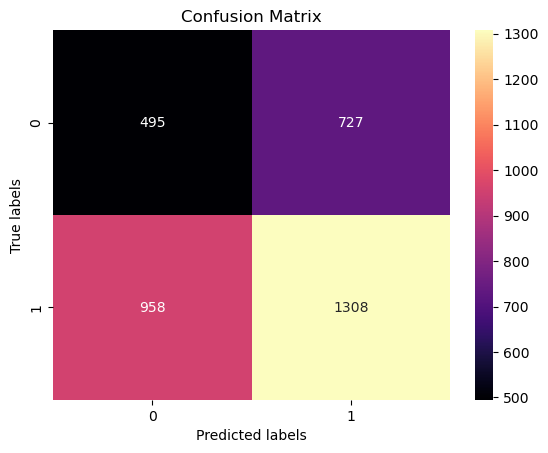

In [26]:
# Get the predicted labels
predicted_labels = kmeans.labels_

# Get the true labels (assuming they are in a variable called true_labels)
true_labels = labels

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt=".0f", cmap="magma")

# Add labels to the plot

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()


# Predicted Labels vs True Labels - Clustering


727


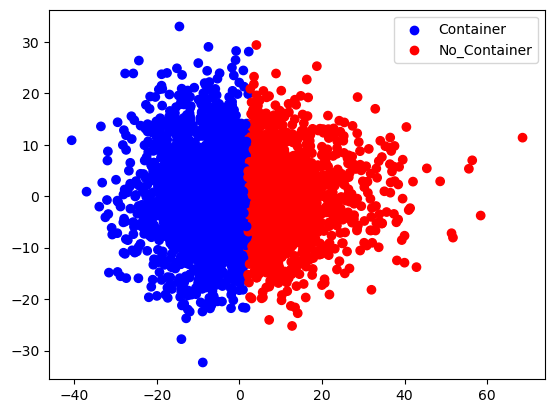

In [59]:
# Find the misclassified data points
false_positives = np.where((true_labels == 0) & (predicted_labels == 1))[0]
false_negatives = np.where((true_labels == 1) & (predicted_labels == 0))[0]

# Visualize the clusters in 2D space using the first two principal components
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=predicted_labels, cmap=ListedColormap(colors))

# Add a legend to the plot

%matplotlib inline
plt.show()

727


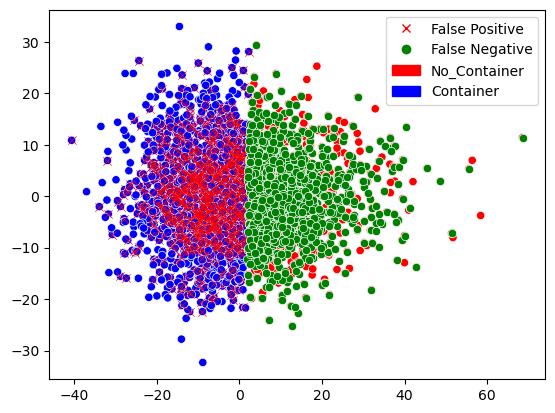

In [68]:
# Find the misclassified data points
false_positives = np.where((true_labels == 0) & (predicted_labels == 1))[0]
false_negatives = np.where((true_labels == 1) & (predicted_labels == 0))[0]

# Visualize the clusters in 2D space using the first two principal components
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=predicted_labels, palette=colors)

# Add false positives and false negatives to the plot
sns.scatterplot(x=pca_result[false_positives, 0], y=pca_result[false_positives, 1], marker='x', color='r', label='False Positive')
sns.scatterplot(x=pca_result[false_negatives, 0], y=pca_result[false_negatives, 1], marker='o', color='g', label='False Negative')

# Create legend with the same colors
handles = [plt.Line2D([], [], linestyle='None', marker='x', color='r', label='False Positive'),
           plt.Line2D([], [], linestyle='None', marker='o', color='g', label='False Negative')]
handles += [mpatches.Patch(color=color, label=label) for color, label in zip(colors, ['No_Container', 'Container'])]

plt.legend(handles=handles, loc='upper right')

print(len(false_positives))
%matplotlib inline
plt.show()

# DBSCAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


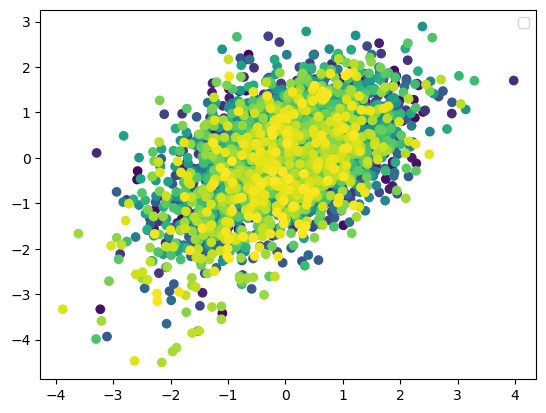

In [70]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=1)
clusters = dbscan.fit_predict(features_2d)

# Plot the clusters
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap="viridis")
plt.legend()
plt.show()


In [68]:
clusters.shape

(3488,)

# LDA(Linear Discriminant Analysis)


In [59]:
# Instantiate the LDA model and fit it to the data
lda = LinearDiscriminantAnalysis()
lda_result = lda.fit_transform(pca_result, labels)


In [60]:
print(lda_result.shape)

(3488, 1)


In [40]:
lda_result_0 = lda_result[labels==0]

In [41]:
lda_result_0

array([[-1.30225935],
       [ 0.05652158],
       [ 0.99550709],
       ...,
       [ 1.17313579],
       [ 1.3691623 ],
       [ 0.99479695]])

In [42]:
lda_result_1 = lda_result[labels==1]

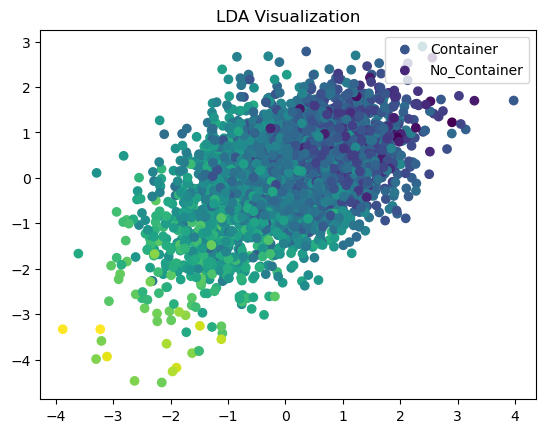

In [74]:
# indices = labels == 0
# indices1 = labels == 1

# Plot the data using different colors for each class
fig, ax = plt.subplots()


# This plots using the 0th column as x and 1st column as y
ax.scatter(features_2d_0[:, 0], features_2d_0[:, 1], c='lda_result_0', label='Container')
ax.scatter(features_2d_1[:, 0], features_2d_1[:, 1], c=lda_result_1, label='No_Container')

# 0 is container and 1 is no container
plt.legend(loc="upper right")

# Set the title and show the plot
ax.set_title("LDA Visualization")
plt.show()


In [110]:
features1[:, 1]

array([ 1.7341864,  1.4792389,  0.4897305, ..., -1.8730259, -1.8439274,
       -0.6374895], dtype=float32)

In [112]:
features1[:, 0]

array([[ 0.9578631 ,  1.7341864 ,  0.08538779, ..., -0.28156617,
         0.17381935,  0.69571465],
       [-0.68409383,  1.4792389 ,  0.50605595, ..., -1.1951295 ,
        -0.1751789 ,  0.39030302],
       [-1.2169716 ,  0.4897305 ,  0.03768349, ..., -0.6940949 ,
        -1.2008945 ,  0.4508954 ],
       ...,
       [-1.6385298 , -1.8730259 , -0.93363637, ..., -1.5092738 ,
        -2.0578365 , -0.08520333],
       [-1.3565004 , -1.8439274 , -0.7920293 , ..., -1.2772357 ,
        -1.0445502 ,  0.00387176],
       [ 0.05886658, -0.6374895 ,  0.6268838 , ..., -0.01155739,
        -1.3467313 ,  0.16417651]], dtype=float32)

In [89]:
features_2d.shape

(3488, 1000)

In [61]:
np.bincount(labels)

array([1222, 2266])

In [ ]:
# Reshape the feature maps into a 2D array and use clustering algorithms such as KMeans, DBSCAN, or Hierarchical clustering to cluster the feature vectors
# umap_model = umap.UMAP(n_components=2, random_state=0).fit_transform(features_2d)

# cmap = ListedColormap(['red', 'green', 'blue', 'yellow', 'purple'])

# batch_size = 500
# n_clusters = 5
# n_batches = int(np.ceil(features_2d.shape[0] / batch_size))
# kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=0)
# for i in range(n_batches):
#     features_batch = features_2d[i*batch_size:(i+1)*batch_size]
#     kmeans.partial_fit(features_batch)
#     umap_embeddings = umap_model.UMAP(n_components=2, random_state=0).fit_transform(features_batch)
#     plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels[i*batch_size:(i+1)*batch_size], cmap=cmap)

# plt.show()


In [ ]:
# plt.scatter(tsne[:,0], tsne[:,1], c=kmeans.labels_)
# plt.show()

# plt.scatter(pca[:,0], pca[:,1], c=kmeans.labels_)
# plt.show()


In [ ]:
# # Visualize the clustered feature vectors using scatter plots, t-SNE, or PCA to gain insights into the learned features
# features_2d = features.reshape(features.shape[0], -1)
# tsne = TSNE(n_components=2, random_state=0).fit_transform(features_2d)
# pca = PCA(n_components=2).fit_transform(features_2d)

# plt.scatter(tsne[:,0], tsne[:,1], c=kmeans.labels_)
# plt.show()

# plt.scatter(pca[:,0], pca[:,1], c=kmeans.labels_)
# plt.show()


In [ ]:
# kmeans = KMeans(n_clusters=3, random_state=0).fit(features_2d)


In [ ]:
# # Reshape the feature maps into a 2D array and use clustering algorithms such as KMeans, DBSCAN, or Hierarchical clustering to cluster the feature vectors
# features_2d = features.reshape(features.shape[0], -1)
# kmeans = KMeans(n_clusters=5, random_state=0).fit(features_2d)

# # Visualize the clustered feature vectors using scatter plots, t-SNE, or PCA to gain insights into the learned features
# tsne = TSNE(n_components=2, random_state=0).fit_transform(features_2d)
# pca = PCA(n_components=2).fit_transform(features_2d)

# plt.scatter(tsne[:,0], tsne[:,1], c=kmeans.labels_)
# plt.show()

# plt.scatter(pca[:,0], pca[:,1], c=kmeans.labels_)
# plt.show()
